In [1]:
!pip3 install openai==0.28.0
!pip install pygame
!pip install matplotlib

In [66]:
import gym
from gym import spaces
import pygame
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import json
import random
from constants import MEDIUM_LEVEL_ACTIONS, ALL_DESTINATIONS


In [67]:
info = dict()
with open("699_recipe_data.json", "r") as f:
    d = json.load(f)
    for i in d["dataset"]:
      e = i["key"]
      if e not in info.keys():
          v = i["value"]
          n_v = set()
          for value in v:
              n_v.add(tuple(value))
          info[e] = n_v
      else:
          value = info[e]
          v = i["value"]
          n_v = set()
          for elements in v:
              n_v.add(tuple(elements))
          n_v = value.union(n_v)
          info[e] = n_v

#info key is command, value is set with multiple solutions and each solution type is tuple
print(info)

{'Serve Apple Salad to Person in Red': {('Go to Red Apple', 'Take Red Apple', 'Go to Green Apple', 'Take Green Apple', 'Go to Knife', 'Prepare', 'Go to Mixing Bowl', 'Prepare', 'Place Apple Salad on Plate', 'Serve plate to Person in Red'), ('Go to Green Apple', 'Take Green Apple', 'Go to Red Apple', 'Take Red Apple', 'Go to Knife', 'Prepare', 'Go to Mixing Bowl', 'Prepare', 'Place Apple Salad on Plate', 'Serve plate to Person in Red')}, 'Cheese Platter for Customer in White': {('Go to White Cheese', 'Take White Cheese', 'Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to Knife', 'Prepare', 'Go to Plate', 'Place White Cheese on Plate', 'Place Yellow Cheese on Plate', 'Serve plate to Person in White'), ('Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to White Cheese', 'Take White Cheese', 'Go to Knife', 'Prepare', 'Go to Plate', 'Place White Cheese on Plate', 'Place Yellow Cheese on Plate', 'Serve plate to Person in White')}, 'Serve Cheese and Herb Spread to Customer in Green': {('Go to

In [79]:
# from abc import update_abstractmethods
env_items={
  "ingredients": [
    "Red Onions",
    "Yellow Onions",
    "Bread",
    "Yellow Cheese",
    "White Cheese",
    "Red Bell Pepper",
    "Green Bell Pepper",
    "Red Apple",
    "Green Apple",
    "Yellow Egg",
    "White Egg",
    "Butter",
    "Ham",
    "Red Meat (Beef)",
    "White Meat (Turkey)",
    "Salt",
    "Herbs"
  ],
  "kitchenTools": [
    "Plate",
    "Pot",
    "Oven",
    "Knife",
    "Mixing Bowl"
  ]
}

action_list={
  "actions": [
    "Go to",
    "Prepare",
    "Take",
    "Place",
    "Serve"
  ]
}


#reference from https://www.gymlibrary.dev/content/environment_creation/
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, the_size=15):
        self.size = the_size
        self.window_size = 1000

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None

        self.counter = 0
        self.food_list = ["RedApple", "RedOnions", "YellowOnions", "Bread", "YellowCheese", "WhiteCheese",
         "RedBellPepper", "GreenBellPepper", "GreenApple", "YellowEgg", "WhiteEgg", "Butter",
         "Ham", "RedMeat", "WhiteMeat", "Salt", "Herbs"]

        self.tools_list =[ "Pot", "Oven", "Knife", "MixingBowl"]

        self.guest_list = ["Red","White","Green","Yellow"]

        #It is a list of food that agent is taking
        self.taking_item = []

        all_obs = {"Agent": spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "RedApple": spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "RedOnions":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "YellowOnions":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Bread":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "YellowCheese":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "WhiteCheese":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "RedBellPepper":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "GreenBellPepper":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "GreenApple":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "YellowEgg":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "WhiteEgg":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Butter":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Ham":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "RedMeat":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "WhiteMeat":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Salt":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Herbs":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Pot":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Oven":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Knife":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "MixingBowl":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "Plate":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "RedGuest":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "WhiteGuest":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "GreenGuest":spaces.Box(0, the_size - 1, shape=(2,), dtype=int),
                   "YellowGuest":spaces.Box(0, the_size - 1, shape=(2,), dtype=int)}
        self.observation_space = spaces.Dict(all_obs)
        self.action = spaces.Discrete(8)

        right = np.array([1,0])
        left = np.array([-1,0])
        up = np.array([0,1])
        down = np.array([0,-1])

        self._action_to_direction = {0: right,1: left,2: down,3: up}

        all_locations = [np.array([x, y]) for x in range(self.size) for y in range(self.size)]

        # Shuffle the locations
        random.shuffle(all_locations)


        # It is a map that stores all locations of food, tools, and guest
        self.map_info = [[None for _ in range(self.size)] for _ in range(self.size)]
        
        # It is a dictionary that record which food has been processed by which tool
        self.food_on = dict()
        
        for item in self.food_list:
            location = all_locations.pop()
            x = location[0]
            y = location[1]
            setattr(self, f'_{item}_location', location)
            self.map_info[x][y] = item
            self.food_on[item] = None
            # key_name = f'_{item}_location'
            # self.all_loc[key_name] = location

        
        for item in self.tools_list:
            location = all_locations.pop()
            setattr(self, f'_{item}_location', location)
            x = location[0]
            y = location[1]
            self.map_info[x][y] = item

        for guest in self.guest_list:
            location = all_locations.pop()
            setattr(self, f'_{guest}_location', location)
            x = location[0]
            y = location[1]
            self.map_info[x][y] = guest
            # key_name = f'_{item}_location'
            # self.all_loc[key_name] = location

        p_loc = all_locations.pop()
        setattr(self, '_Plate_location', p_loc)
        x = p_loc[0]
        y = p_loc[1]
        self.map_info[x][y] = "Plate"
        # print(self.map_info)

        a_loc = all_locations.pop()
        setattr(self, '_Agent_location', a_loc)
        


    def _get_obs(self):
        return {"Agent": self._Agent_location,
                "Red Apple": self._RedApple_location,
                "Red Onions": self._RedOnions_location,
                "Yellow Onions": self._YellowOnions_location,
                "Bread": self._Bread_location,
                "Yellow Cheese": self._YellowCheese_location,
                "White Cheese": self._WhiteCheese_location,
                "Red Bell Pepper": self._RedBellPepper_location,
                "Green Bell Pepper": self._GreenBellPepper_location,
                "Green Apple": self._GreenApple_location,
                "Yellow Egg": self._YellowEgg_location,
                "White Egg": self._WhiteEgg_location,
                "Butter": self._Butter_location,
                "Ham": self._Ham_location,
                "Red Meat (Beef)": self._RedMeat_location,
                "White Meat (Turkey)": self._WhiteMeat_location,
                "Salt": self._Salt_location,
                "Herbs": self._Herbs_location,
                "Pot": self._Pot_location,
                "Oven": self._Oven_location,
                "Knife": self._Knife_location,
                "Mixing Bowl": self._MixingBowl_location,
                "Plate": self._Plate_location,
                "RedGuest": self._Red_location,
                "WhiteGuest": self._White_location,
                "GreenGuest": self._Green_location,
                "YellowGuest": self._Yellow_location
                }

    #It will return a dictionary that contains all distances between agent and food, tools, and guest. Also it will return a list of food that agent is taking
    def _get_info(self):
        redapple_dis = np.linalg.norm(self._Agent_location - self._RedApple_location, ord=1)
        redonions_dis = np.linalg.norm(self._Agent_location - self._RedOnions_location, ord=1)
        yellowonions_dis = np.linalg.norm(self._Agent_location - self._YellowOnions_location, ord=1)
        bread_dis = np.linalg.norm(self._Agent_location - self._Bread_location, ord=1)
        yellowcheese_dis = np.linalg.norm(self._Agent_location - self._YellowCheese_location, ord=1)
        whitecheese_dis = np.linalg.norm(self._Agent_location - self._WhiteCheese_location, ord=1)
        redbellpepper_dis = np.linalg.norm(self._Agent_location - self._RedBellPepper_location, ord=1)
        greenbellpepper_dis = np.linalg.norm(self._Agent_location - self._GreenBellPepper_location, ord=1)
        greenapple_dis = np.linalg.norm(self._Agent_location - self._GreenApple_location, ord=1)
        yellowegg_dis = np.linalg.norm(self._Agent_location - self._YellowEgg_location, ord=1)
        whiteegg_dis = np.linalg.norm(self._Agent_location - self._WhiteEgg_location, ord=1)
        butter_dis = np.linalg.norm(self._Agent_location - self._Butter_location, ord=1)
        ham_dis = np.linalg.norm(self._Agent_location - self._Ham_location, ord=1)
        redmeat_dis = np.linalg.norm(self._Agent_location - self._RedMeat_location, ord=1)
        whitemeat_dis = np.linalg.norm(self._Agent_location - self._WhiteMeat_location, ord=1)
        salt_dis = np.linalg.norm(self._Agent_location - self._Salt_location, ord=1)
        herbs_dis = np.linalg.norm(self._Agent_location - self._Herbs_location, ord=1)
        pot_dis = np.linalg.norm(self._Agent_location - self._Pot_location, ord=1)
        oven_dis = np.linalg.norm(self._Agent_location - self._Oven_location, ord=1)
        knife_dis = np.linalg.norm(self._Agent_location - self._Knife_location, ord=1)
        mixingbowl_dis = np.linalg.norm(self._Agent_location - self._MixingBowl_location, ord=1)
        plate_dis = np.linalg.norm(self._Agent_location - self._Plate_location, ord=1)
        redGuest_dis = np.linalg.norm(self._Agent_location - self._Red_location, ord=1)
        whiteGuest_dis = np.linalg.norm(self._Agent_location - self._White_location, ord=1)
        greenGuest_dis = np.linalg.norm(self._Agent_location - self._Green_location, ord=1)
        yellowGuest_dis = np.linalg.norm(self._Agent_location - self._Yellow_location, ord=1)

        # Add each distance to a dictionary
        distances = {
            "distance to Red Apple": redapple_dis,
            "distance to Red Onions": redonions_dis,
            "distance to Yellow Onions": yellowonions_dis,
            "distance to Bread": bread_dis,
            "distance to Yellow Cheese": yellowcheese_dis,
            "distance to White Cheese": whitecheese_dis,
            "distance to Red Bell Pepper": redbellpepper_dis,
            "distance to Green Bell Pepper": greenbellpepper_dis,
            "distance to Green Apple": greenapple_dis,
            "distance to Yellow Egg": yellowegg_dis,
            "distance to White Egg": whiteegg_dis,
            "distance to Butter": butter_dis,
            "distance to Ham": ham_dis,
            "distance to Red Meat (Beef)": redmeat_dis,
            "distance to White Meat (Turkey)": whitemeat_dis,
            "distance to Salt": salt_dis,
            "distance to Herbs": herbs_dis,
            "distance to Pot": pot_dis,
            "distance to Oven": oven_dis,
            "distance to Knife": knife_dis,
            "distance to Mixing Bowl": mixingbowl_dis,
            "distance to Plate": plate_dis,
            "distance to Red Guest": redGuest_dis,
            "distance to White Guest": whiteGuest_dis,
            "distance to Green Guest": greenGuest_dis,
            "distance to Yellow Guest": yellowGuest_dis
        }

        return distances, self.taking_item

    def taking(self):
        pos = self._Agent_location
        x = pos[0]
        y = pos[1]
        if self.map_info[x][y]!=None:
          if self.map_info[x][y] in self.food_list:
            self.taking_item.append(self.map_info[x][y])
            return True, "U took the " + str(self.taking_item), self.map_info[x][y]
          else:
             item = self.map_info[x][y]
             return False, "U got nothing from "+str(item), None
                
        else:
          False,"Nothing", None



    def drop(self,item):
      if len(self.taking_item)==0:
        return False, "U did not take anythings", None
      else:
        pos = self._Agent_location
        x = pos[0]
        y = pos[1]
        if self.map_info[x][y]==None:
          info = "U need to drop food on tools"
          return False, info, None
        else:
          if self.map_info[x][y] in self.food_list:
            return False, "U can not drop on food loc", None
          elif self.map_info[x][y] in self.tools_list or self.map_info[x][y]=="Plate":
            v = self.food_on[item]
            if v != None:
              self.food_on[item].append(self.map_info[x][y])
              return True, "U dropped "+str(item)+" on "+str(self.map_info[x][y]), item
            else:
              self.food_on[item] = [self.map_info[x][y]]
              return True, "U dropped "+str(item)+" on "+str(self.map_info[x][y]), item
              



    def step(self,action,target):
        points = 0
        terminate = False
        if action >=1 and action <=4:
          direction = self._action_to_direction[action]
          self._Agent_location += direction
          points, terminate = self.rewardMoving(target)
          self._Agent_location = np.clip(self._Agent_location, 0, self.size - 1)
        if action == 5: ##taking       
            points = -0.02
            terminate = False
        if action == 6: #prepare and place
            points = -0.02
            terminate = False
        
           
        self.counter += 1
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()


        return observation, points, terminate, info

    def rewardMoving(self,target):
        pos = self._Agent_location
        x = pos[0]
        y = pos[1]
        
        if self.map_info[x][y] == target:
              return 1, True
        return -0.01, False
    
    def rewardTaking(self, target,item_get):
        if item_get == target:
           return 0.02, False
        else:
           return -0.02, False
        
    def prepareReward(self,food):
        pos = self._Agent_location
        x = pos[0]
        y = pos[1]
        if self.map_info[x][y] in self.tools_list:
            if self.map_info[x][y]!="Knife":
              if food in self.food_list:
                return 0.02, False
              else:
                return -0.01, False
            else:
              if food not in self.food_list:
                return 0.02, False
              else:
                return -0.01, False
        elif self.map_info[x][y] == "Plate":
              if food not in self.food_list:
                return 0.02, False
              else:
                return -0.01, False
        else:
           return -0.02, False
        
    
           

    # Implement the logic to verify 'Go to' action       
    def _verify_go_to(self, target):
        
        location={"Agent": self._Agent_location,
                "Red Apple": self._RedApple_location,
                "Red Onions": self._RedOnions_location,
                "Yellow Onions": self._YellowOnions_location,
                "Bread": self._Bread_location,
                "Yellow Cheese": self._YellowCheese_location,
                "White Cheese": self._WhiteCheese_location,
                "Red Bell Pepper": self._RedBellPepper_location,
                "Green Bell Pepper": self._GreenBellPepper_location,
                "Green Apple": self._GreenApple_location,
                "Yellow Egg": self._YellowEgg_location,
                "White Egg": self._WhiteEgg_location,
                "Butter": self._Butter_location,
                "Ham": self._Ham_location,
                "Red Meat (Beef)": self._RedMeat_location,
                "White Meat (Turkey)": self._WhiteMeat_location,
                "Salt": self._Salt_location,
                "Herbs": self._Herbs_location,
                "Pot": self._Pot_location,
                "Oven": self._Oven_location,
                "Knife": self._Knife_location,
                "Mixing Bowl": self._MixingBowl_location,
                "Plate": self._Plate_location,
                "RedGuest": self._Red_location,
                "WhiteGuest": self._White_location,
                "GreenGuest": self._Green_location,
                "YellowGuest": self._Yellow_location
                }

        # Check if the target is a valid location or item in the environment
        target_location = location[target]
        if target_location is not None:
            # Check if the agent is at the target location
            if np.array_equal(self._Agent_location, target_location):
                return True
            else:
                return False
        else:
            return False



    # def check_reach_plate(self):
    #     if np.array_equal(self._Plate_location, self._agent_location):
    #         self.has_apple = True
    #         return True
    #     else:
    #         return False

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        all_locations = [np.array([x, y]) for x in range(self.size) for y in range(self.size)]

        # Shuffle the locations
        random.shuffle(all_locations)

        # self.all_loc = dict()
        # Assign unique locations to each item

        self.map_info = [[None for _ in range(self.size)] for _ in range(self.size)]
        self.food_on = dict()
        for item in self.food_list:
            location = all_locations.pop()
            x = location[0]
            y = location[1]
            setattr(self, f'_{item}_location', location)
            self.map_info[x][y] = item
            self.food_on[item] = None
            # key_name = f'_{item}_location'
            # self.all_loc[key_name] = location
        
        for item in self.tools_list:
            location = all_locations.pop()
            setattr(self, f'_{item}_location', location)
            x = location[0]
            y = location[1]
            self.map_info[x][y] = item

        p_loc = all_locations.pop()
        setattr(self, '_Plate_location', p_loc)
        x = p_loc[0]
        y = p_loc[1]
        self.map_info[x][y] = "Plate"
        # print(self.map_info)

        a_loc = all_locations.pop()
        setattr(self, '_Agent_location', a_loc)

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def render(self):
      if self.render_mode == "rgb_array":
        return self._render_frame()

    


    def _render_frame(self):
      surface_size = (self.window_size*2, self.window_size*2)  # Example: 900x900 window size
      self.window_size = max(surface_size)
      print(self.window_size)

      if self.render_mode == "human":
          if self.window is None:
              self.clock = pygame.time.Clock()
              pygame.init()
              pygame.display.init()
              self.window = pygame.display.set_mode(surface_size)

      canvas = pygame.Surface(surface_size)
      canvas.fill((255, 255, 255))

      # Scale factor for the grid squares
      s = (self.window_size / 30) # Adjust '30' to your grid size
      pix_square_size = s
      redApple_pic = pygame.image.load("images/redApple.jpeg")
      redApple_pic = pygame.transform.scale(redApple_pic, (int(pix_square_size ), int(pix_square_size)))
      redApple_pos = (self._RedApple_location[0] * pix_square_size, self._RedApple_location[1] * pix_square_size)

      redOnions_pic = pygame.image.load("images/redOnions.jpeg")
      redOnions_pic = pygame.transform.scale(redOnions_pic, (int(pix_square_size ), int(pix_square_size)))
      redOnions_pos = (self._RedOnions_location[0] * pix_square_size, self._RedOnions_location[1] * pix_square_size)

      yellowOnions_pic = pygame.image.load("images/yellowOnions.jpeg")
      yellowOnions_pic = pygame.transform.scale(yellowOnions_pic, (int(pix_square_size ), int(pix_square_size)))
      yellowOnions_pos = (self._YellowOnions_location[0] * pix_square_size, self._YellowOnions_location[1] * pix_square_size)

      bread_pic = pygame.image.load("images/Bread.jpeg")
      bread_pic = pygame.transform.scale(bread_pic, (int(pix_square_size ), int(pix_square_size)))
      bread_pos = (self._Bread_location[0] * pix_square_size, self._Bread_location[1] * pix_square_size)

      yellowCheese_pic = pygame.image.load("images/yellowCheese.jpeg")
      yellowCheese_pic = pygame.transform.scale(yellowCheese_pic, (int(pix_square_size ), int(pix_square_size)))
      yellowCheese_pos = (self._YellowCheese_location[0] * pix_square_size, self._YellowCheese_location[1] * pix_square_size)

      whiteCheese_pic = pygame.image.load("images/whiteCheese.jpeg")
      whiteCheese_pic = pygame.transform.scale(whiteCheese_pic, (int(pix_square_size ), int(pix_square_size)))
      whiteCheese_pos = (self._WhiteCheese_location[0] * pix_square_size, self._WhiteCheese_location[1] * pix_square_size)

      redBellPepper_pic = pygame.image.load("images/redBellPepper.jpeg")
      redBellPepper_pic = pygame.transform.scale(redBellPepper_pic, (int(pix_square_size ), int(pix_square_size)))
      redBellPepper_pos = (self._RedBellPepper_location[0] * pix_square_size, self._RedBellPepper_location[1] * pix_square_size)

      greenBellPepper_pic = pygame.image.load("images/greenBellPepper.jpeg")
      greenBellPepper_pic = pygame.transform.scale(greenBellPepper_pic, (int(pix_square_size ), int(pix_square_size)))
      greenBellPepper_pos = (self._GreenBellPepper_location[0] * pix_square_size, self._GreenBellPepper_location[1] * pix_square_size)

      greenApple_pic = pygame.image.load("images/greenApple.jpeg")
      greenApple_pic = pygame.transform.scale(greenApple_pic, (int(pix_square_size ), int(pix_square_size)))
      greenApple_pos = (self._GreenApple_location[0] * pix_square_size, self._GreenApple_location[1] * pix_square_size)

      yellowEgg_pic = pygame.image.load("images/yellowEgg.jpeg")
      yellowEgg_pic = pygame.transform.scale(yellowEgg_pic, (int(pix_square_size ), int(pix_square_size)))
      yellowEgg_pos = (self._YellowEgg_location[0] * pix_square_size, self._YellowEgg_location[1] * pix_square_size)

      whiteEgg_pic = pygame.image.load("images/whiteEgg.jpeg")
      whiteEgg_pic = pygame.transform.scale(whiteEgg_pic, (int(pix_square_size ), int(pix_square_size)))
      whiteEgg_pos = (self._WhiteEgg_location[0] * pix_square_size, self._WhiteEgg_location[1] * pix_square_size)

      butter_pic = pygame.image.load("images/Butter.jpeg")
      butter_pic = pygame.transform.scale(butter_pic, (int(pix_square_size ), int(pix_square_size)))
      butter_pos = (self._Butter_location[0] * pix_square_size, self._Butter_location[1] * pix_square_size)

      ham_pic = pygame.image.load("images/Ham.jpeg")
      ham_pic = pygame.transform.scale(ham_pic, (int(pix_square_size ), int(pix_square_size)))
      ham_pos = (self._Ham_location[0] * pix_square_size, self._Ham_location[1] * pix_square_size)

      redMeat_pic = pygame.image.load("images/redMeat.jpeg")
      redMeat_pic = pygame.transform.scale(redMeat_pic, (int(pix_square_size ), int(pix_square_size)))
      redMeat_pos = (self._RedMeat_location[0] * pix_square_size, self._RedMeat_location[1] * pix_square_size)

      whiteMeat_pic = pygame.image.load("images/whiteMeat.jpeg")
      whiteMeat_pic = pygame.transform.scale(whiteMeat_pic, (int(pix_square_size ), int(pix_square_size)))
      whiteMeat_pos = (self._WhiteMeat_location[0] * pix_square_size, self._WhiteMeat_location[1] * pix_square_size)

      salt_pic = pygame.image.load("images/Salt.jpeg")
      salt_pic = pygame.transform.scale(salt_pic, (int(pix_square_size ), int(pix_square_size)))
      salt_pos = (self._Salt_location[0] * pix_square_size, self._Salt_location[1] * pix_square_size)

      herbs_pic = pygame.image.load("images/Herbs.jpeg")
      herbs_pic = pygame.transform.scale(herbs_pic, (int(pix_square_size ), int(pix_square_size)))
      herbs_pos = (self._Herbs_location[0] * pix_square_size, self._Herbs_location[1] * pix_square_size)

      pot_pic = pygame.image.load("images/Pot.jpeg")
      pot_pic = pygame.transform.scale(pot_pic, (int(pix_square_size ), int(pix_square_size)))
      pot_pos = (self._Pot_location[0] * pix_square_size, self._Pot_location[1] * pix_square_size)

      oven_pic = pygame.image.load("images/Oven.jpeg")
      oven_pic = pygame.transform.scale(oven_pic, (int(pix_square_size ), int(pix_square_size)))
      oven_pos = (self._Oven_location[0] * pix_square_size, self._Oven_location[1] * pix_square_size)

      knife_pic = pygame.image.load("images/Knife.jpeg")
      knife_pic = pygame.transform.scale(knife_pic, (int(pix_square_size ), int(pix_square_size)))
      knife_pos = (self._Knife_location[0] * pix_square_size, self._Knife_location[1] * pix_square_size)

      mixingBowl_pic = pygame.image.load("images/mixingBowl.jpeg")
      mixingBowl_pic = pygame.transform.scale(mixingBowl_pic, (int(pix_square_size ), int(pix_square_size)))
      mixingBowl_pos = (self._MixingBowl_location[0] * pix_square_size, self._MixingBowl_location[1] * pix_square_size)

      plate_pic = pygame.image.load("images/Plate.jpeg")
      plate_pic = pygame.transform.scale(plate_pic, (int(pix_square_size ), int(pix_square_size)))
      plate_pos = (self._Plate_location[0] * pix_square_size, self._Plate_location[1] * pix_square_size)




      # Draw the agent, apple, and plate with adjusted sizes
      canvas.blit(redApple_pic, redApple_pos)
      canvas.blit(plate_pic, plate_pos)
      canvas.blit(redOnions_pic, redOnions_pos)
      canvas.blit(yellowOnions_pic, yellowOnions_pos)
      canvas.blit(bread_pic, bread_pos)
      canvas.blit(yellowCheese_pic, yellowCheese_pos)
      canvas.blit(whiteCheese_pic, whiteCheese_pos)
      canvas.blit(redBellPepper_pic, redBellPepper_pos)
      canvas.blit(greenBellPepper_pic, greenBellPepper_pos)
      canvas.blit(greenApple_pic, greenApple_pos)
      canvas.blit(yellowEgg_pic, yellowEgg_pos)
      canvas.blit(whiteEgg_pic, whiteEgg_pos)
      canvas.blit(butter_pic, butter_pos)
      canvas.blit(ham_pic, ham_pos)
      canvas.blit(redMeat_pic, redMeat_pos)
      canvas.blit(whiteMeat_pic, whiteMeat_pos)
      canvas.blit(salt_pic, salt_pos)
      canvas.blit(herbs_pic, herbs_pos)
      canvas.blit(pot_pic, pot_pos)
      canvas.blit(oven_pic, oven_pos)
      canvas.blit(knife_pic, knife_pos)
      canvas.blit(mixingBowl_pic, mixingBowl_pos)
      pygame.draw.rect(canvas, 0, pygame.Rect(pix_square_size * self._Agent_location + 10, (pix_square_size * 0.7, pix_square_size * 0.7)))
      pygame.draw.circle(canvas, (0,0,0), (self._Red_location + 0.5) * pix_square_size, (pix_square_size / 3)+1)
      pygame.draw.circle(canvas, (255,0,0), (self._Red_location + 0.5) * pix_square_size, pix_square_size / 3)
      pygame.draw.circle(canvas, (0,0,0), (self._White_location + 0.5) * pix_square_size, (pix_square_size / 3)+1)
      pygame.draw.circle(canvas, (255,255,255), (self._White_location + 0.5) * pix_square_size, pix_square_size / 3)
      pygame.draw.circle(canvas, (0,0,0), (self._Green_location + 0.5) * pix_square_size, (pix_square_size / 3)+1)
      pygame.draw.circle(canvas, (0,255,0), (self._Green_location + 0.5) * pix_square_size, pix_square_size / 3)
      pygame.draw.circle(canvas, (0,0,0), (self._Yellow_location + 0.5) * pix_square_size, (pix_square_size / 3)+1)
      pygame.draw.circle(canvas, (255,255,0), (self._Yellow_location + 0.5) * pix_square_size, pix_square_size / 3)



      # Draw the grid
      for i in range(31):  # Adjust the range for your grid size
          the_pix = pix_square_size * i
          pygame.draw.line(canvas, 0, (0, the_pix), (self.window_size, the_pix), width=3)
          pygame.draw.line(canvas, 0, (the_pix, 0), (the_pix, self.window_size), width=3)

      if self.render_mode != "human":
          return np.transpose(np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2))
      else:
          self.window.blit(canvas, canvas.get_rect())
          pygame.event.pump()
          pygame.display.update()
          self.clock.tick(self.metadata["render_fps"])
          
          


      def close(self):
        if self.window != None:
            pygame.display.quit()
            pygame.quit()
            self.window = None

In [75]:
env = GridWorldEnv(render_mode='rgb_array')

theM = env.map_info
for i in range(len(theM)):
    print(theM[i])

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'WhiteCheese']
[None, None, 'RedMeat', None, None, None, None, None, None, None, None, None, None, None, None]
['WhiteEgg', None, None, None, None, None, 'RedOnions', None, None, None, None, 'YellowOnions', None, None, None]
[None, None, None, None, None, 'Yellow', None, None, None, None, None, None, None, None, None]
[None, None, 'Butter', None, None, None, 'MixingBowl', 'Red', None, None, None, None, None, None, None]
[None, None, None, None, None, 'Ham', None, None, None, None, None, None, None, 'Bread', None]
[None, None, None, None, 'GreenApple', None, None, 'Oven', None, 'White', 'RedBellPepper', None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, 'Herbs', None, None, None, 'Knife', None, None, None, None, None, None, None, 'YellowEgg', N

In [70]:
a,b = env._get_info()

2000


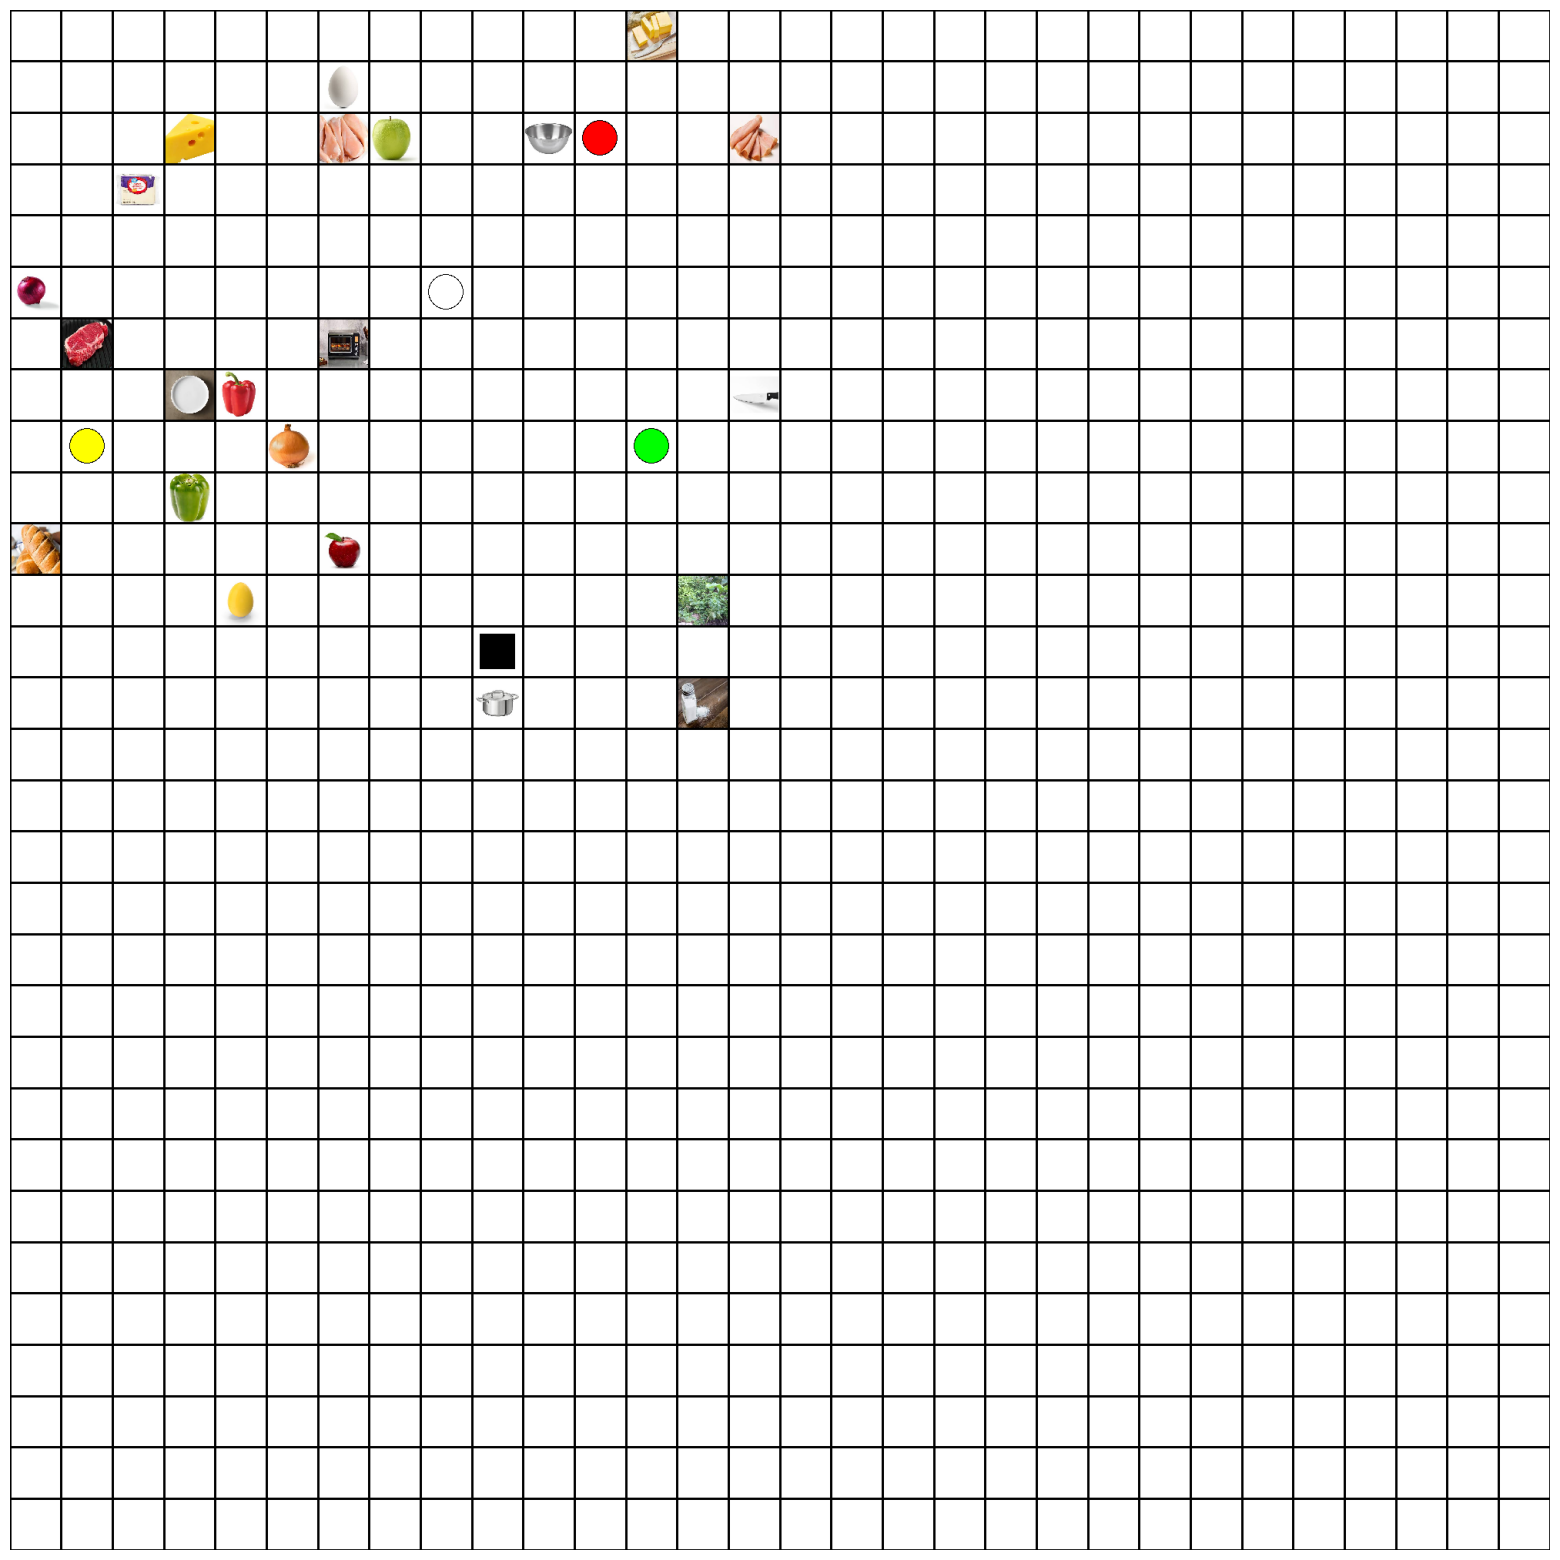

In [71]:
image_array = env._render_frame()

plt.figure(figsize=(20, 20))
# Display the image array
plt.imshow(image_array)
plt.axis('off')  # Hide the axis
plt.show()


In [15]:
print(a)

{'distance to Red Apple': 12.0, 'distance to Red Onions': 12.0, 'distance to Yellow Onions': 10.0, 'distance to Bread': 20.0, 'distance to Yellow Cheese': 13.0, 'distance to White Cheese': 9.0, 'distance to Red Bell Pepper': 9.0, 'distance to Green Bell Pepper': 17.0, 'distance to Green Apple': 6.0, 'distance to Yellow Egg': 6.0, 'distance to White Egg': 10.0, 'distance to Butter': 11.0, 'distance to Ham': 5.0, 'distance to Red Meat (Beef)': 1.0, 'distance to White Meat (Turkey)': 7.0, 'distance to Salt': 16.0, 'distance to Herbs': 13.0, 'distance to Pot': 6.0, 'distance to Oven': 13.0, 'distance to Knife': 2.0, 'distance to Mixing Bowl': 8.0, 'distance to Plate': 14.0, 'distance to Red Guest': 7.0, 'distance to White Guest': 7.0, 'distance to Green Guest': 9.0, 'distance to Yellow Guest': 4.0}


2000


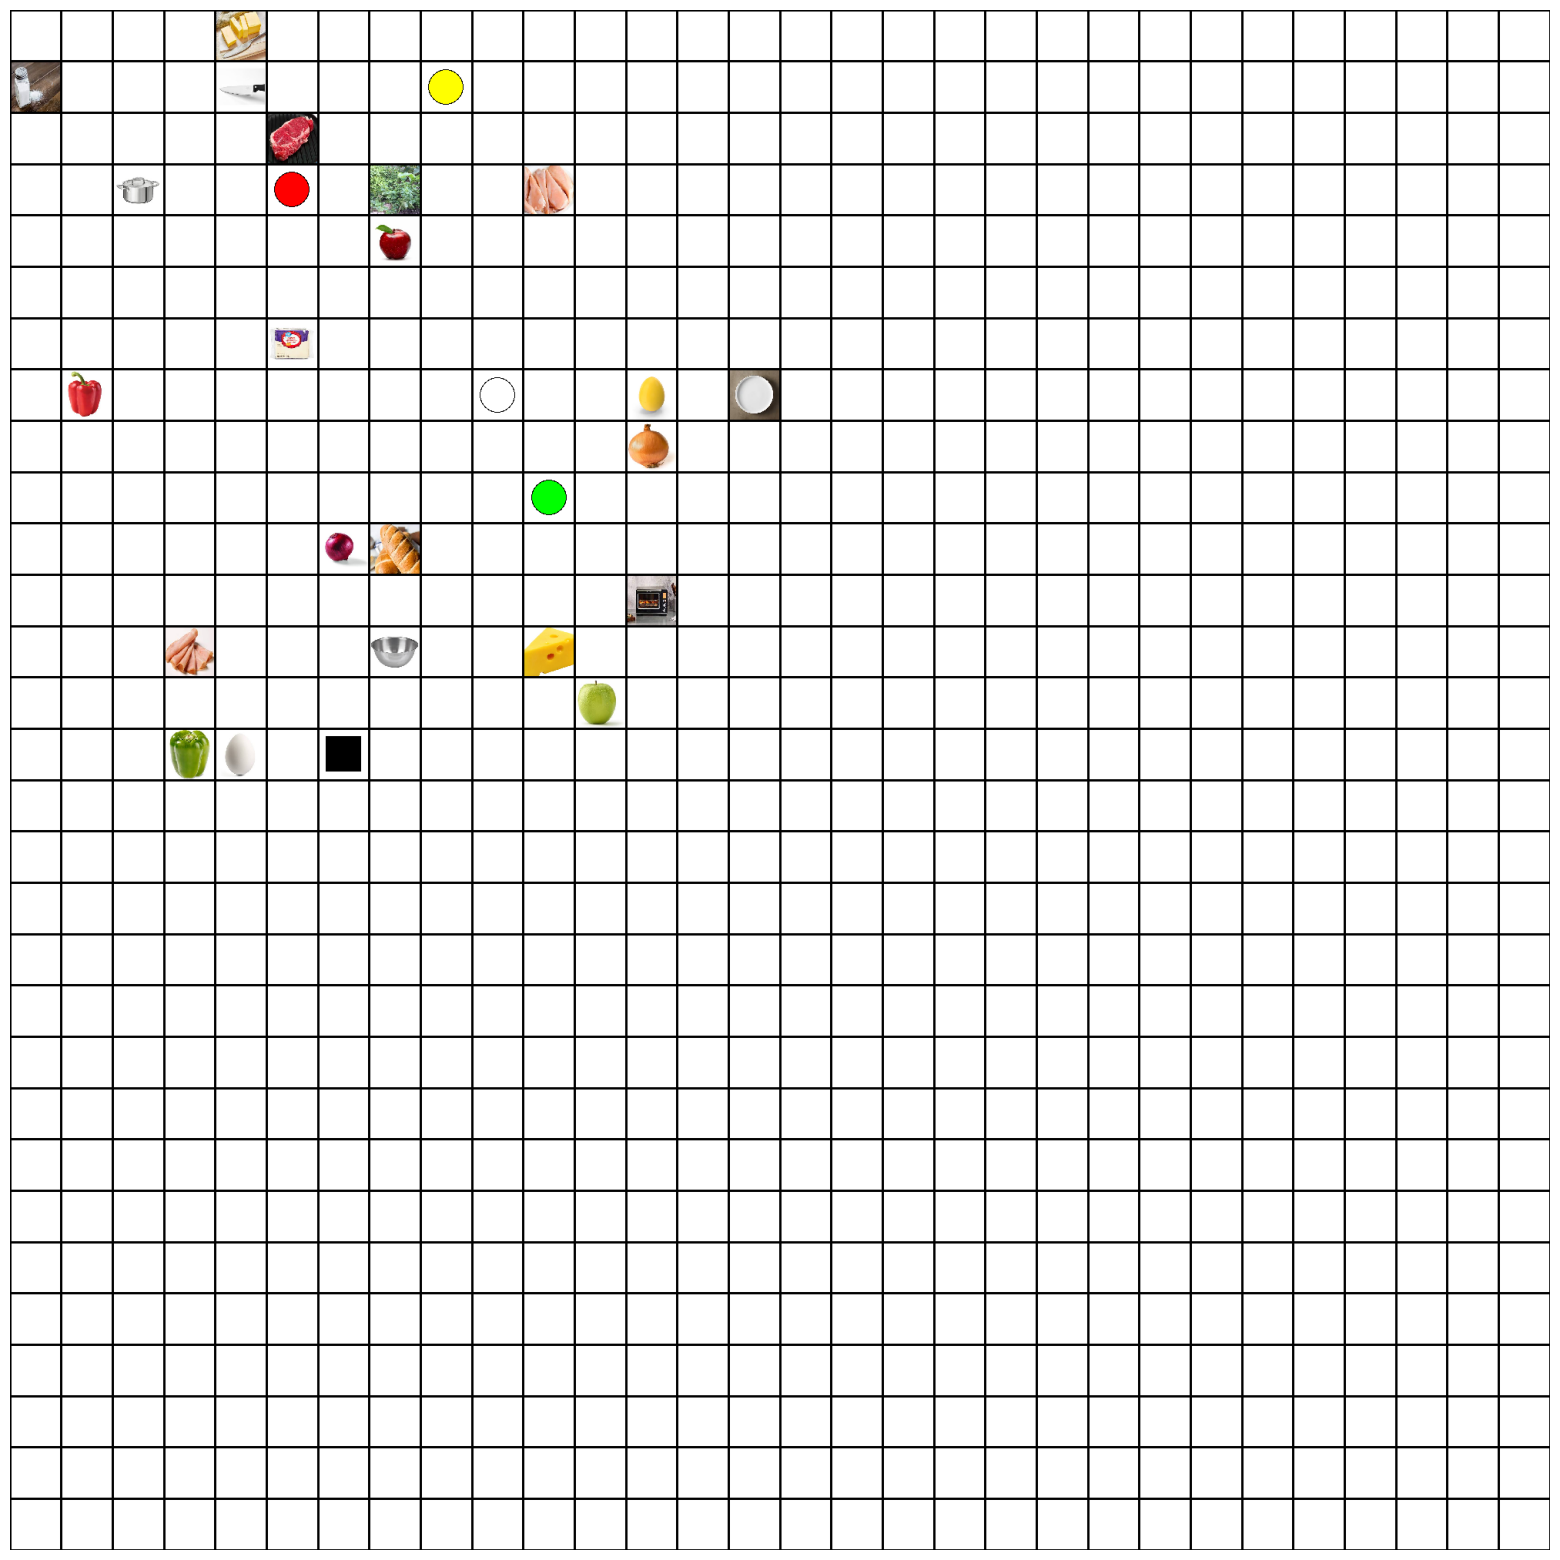

[ 6 13]
[ 6 12]
[ 6 11]
[ 6 10]
[6 9]
[6 8]
[6 7]
[6 6]
[6 5]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6 4]
[6

KeyboardInterrupt: 

In [92]:
action_taken=[]
env = GridWorldEnv(render_mode='rgb_array')
image_array = env._render_frame()

plt.figure(figsize=(20, 20))
# Display the image array
plt.imshow(image_array)
plt.axis('off')  # Hide the axis
plt.show()
def go_to1(target):
    observation=env._get_obs()
    while(not env._verify_go_to(target)):
        pos_agent=observation["Agent"]
        agent_x=pos_agent[0]
        agent_y=pos_agent[1]
        pos_target=observation[target]
        target_x=pos_target[0]
        target_y=pos_target[1]
        if agent_x<target_x:
            observation,_,_,info=env.step(0,target)
            action_taken.append(0)
        elif agent_x>target_x:
            observation,_,_,info=env.step(1,target)
            action_taken.append(1)
        if agent_y>target_y:
            observation,_,_,info=env.step(2,target)
            action_taken.append(2)
        elif agent_y<target_y:
            observation,_,_,info=env.step(3,target)
            action_taken.append(3) 
        print(pos_agent)
go_to1("Red Apple")
print(action_taken)

In [81]:
# This function returns the action of the command
def find_corresponding_action(command):
    for medium_action in MEDIUM_LEVEL_ACTIONS:
        if command.startswith(medium_action):
            return medium_action
    return None

# This function returns the Noun in the command.
def find_destination(command):
    for dest in ALL_DESTINATIONS:
        if dest in command:
            return dest 
    return None

# This function should out put a list of actions for the robot
def computeActionList(command):
    action = find_corresponding_action(command)
    print(action)
    if action == 'Go to':
        dest = find_destination(command)
        print(dest)
        actionList = go_to(dest)
        print(actionList)
        return actionList
    return []
            
def go_to(target):
    action_taken=[]
    observation=env._get_obs()
    while(not env._verify_go_to(target)):
        pos_agent=observation["Agent"]
        agent_x=pos_agent[0]
        agent_y=pos_agent[1]
        pos_target=observation[target]
        target_x=pos_target[0]
        target_y=pos_target[1]
        if agent_x<target_x:
            observation,_,_,info=env.step(0,target)
            action_taken.append(0)
        elif agent_x>target_x:
            observation,_,_,info=env.step(1,target)
            action_taken.append(1)
        if agent_y>target_y:
            observation,_,_,info=env.step(2,target)
            action_taken.append(2)
        elif agent_y<target_y:
            observation,_,_,info=env.step(3,target)
            action_taken.append(3) 
        print(pos_agent)
    return action_taken

In [84]:
# env = GridWorldEnv(render_mode='rgb_array')
print(computeActionList("Go to Red Apple"))

Go to
Red Apple
[]
[]


In [50]:
env = GridWorldEnv(render_mode='rgb_array')
result = {}
for key, values_set in info.items():
    # print(f"Key: {key}")
    arr=[]
    result[key] = arr
    for i in range(10):
        obj = {'seed': i}
        arr.append(obj)
        env.reset(seed=i)
        for value_tuple in values_set:
            actionList = []
            for element in value_tuple:
                actionList = actionList + computerActionList(env, element)
            print(actionList)
print(result)

[ 7 13]
[ 6 13]
[1, 1]
[ 5 13]
[ 4 14]
[ 3 14]
[ 2 14]
[1, 3, 1, 1, 1]


UnboundLocalError: local variable 'points' referenced before assignment